In [1]:
import math
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import statsmodels.api as sm

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import pymc3 as pm
# from pymc3.ode import DifferentialEquation
import arviz as az
import theano


import lmfit
from lmfit.lineshapes import gaussian, lorentzian

# plt.style.use('seaborn-darkgrid')

plt.style.use('ggplot')
font_size = 14
plt.rcParams.update({'font.size': font_size})

/home/asa/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

## Add in CDC Reopen Threshold and replot

In [14]:
# CDC guideline threshold of 10 reported infections per 100k pop every 14 days
reopen_thresh = 10./100000/14
region_init = ('New York','NA')
num_days_smooth = 7
df2, states_pop = get_state_or_county_data(region_init, num_days_smooth)
print(f'Population of {region_init[1]}, {region_init[0]} is {states_pop}.')
state_reopen_thresh = math.ceil(states_pop * reopen_thresh)
print(f'Reopen threshold is {state_reopen_thresh}.')

Population of NA, New York is 19453561.
Reopen threshold is 139.


In [15]:
df2.head() 

,index,date,state,fips,daily_cases,daily_cases_roll7mean,cases,daily_deaths,deaths
0,246,2020-03-01,New York,36,0.0,0.000000,1,0.0,0
1,261,2020-03-02,New York,36,0.0,0.000000,1,0.0,0
2,276,2020-03-03,New York,36,1.0,0.000000,2,0.0,0
3,293,2020-03-04,New York,36,9.0,12.571429,11,0.0,0
4,313,2020-03-05,New York,36,11.0,15.000000,22,0.0,0


In [16]:
pd.to_datetime(max(df2.date)) + pd.DateOffset(1) 

Timestamp('2020-06-03 00:00:00')

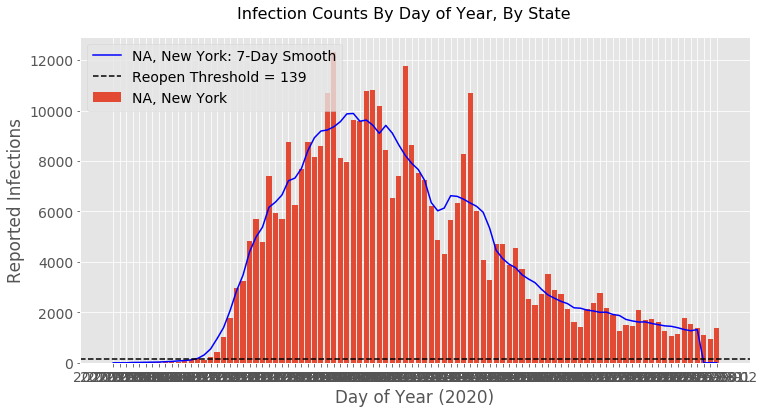

In [17]:
fig, ax = plt.subplots(figsize = (12,6))

ax.bar(df2.date, df2['daily_cases'], label = f'{region_init[1]}, {region_init[0]}')
plt.plot(df2.date, df2[f'daily_cases_roll{num_days_smooth}mean'], 
         label = f"{region_init[1]}, {region_init[0]}: {num_days_smooth}-Day Smooth", color='blue')
ax.axhline(state_reopen_thresh, color = 'black', ls="--", 
           label = f"Reopen Threshold = {state_reopen_thresh}")
ax.legend(loc='upper left')
ax.set_xlabel('Day of Year (2020)') 
ax.set_ylabel('Reported Infections') 
ax.label_outer()
# plt.xticks(np.arange(pd.to_datetime(min(df2.date)), pd.to_datetime(max(df2.date)) + pd.DateOffset(1), 200000))
plt.suptitle('Infection Counts By Day of Year, By State', fontsize=16, y = 0.95)
plt.show();



## Archived - SEIR Modeling

In [29]:
# N = states_pop

N=70000
beta = .65 # infected person infects (beta) other persons per day
D = 3.2 # infections last (D) days
gamma = 1.0 / D
delta = 1.0 / .3 # incubation period of (1/delta) days

E0 = 10
S0, I0, R0 = N-E0, 0, 0
print(S0, E0, I0, R0)
print(f'beta =\t{beta:.3f}\ndelta =\t{delta:.3f}\ngamma =\t{gamma:.3f}\nR_0 =\t{beta/gamma:.3f}')

69990 10 0 0
beta =	0.650
delta =	3.333
gamma =	0.312
R_0 =	2.080


In [34]:
start_doy = 0
end_doy = 70
n_doy = end_doy - start_doy + 1
t = np.linspace(start_doy,end_doy,n_doy)
# t_datetime = [pd.to_datetime(2020 * 1000 + t1[i], format='%Y%j') for i in range(len(t1))]
# Initial conditions vector
y0 = S0, E0, I0, R0
print(y0)
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_seir_fixed, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

(69990, 10, 0, 0)


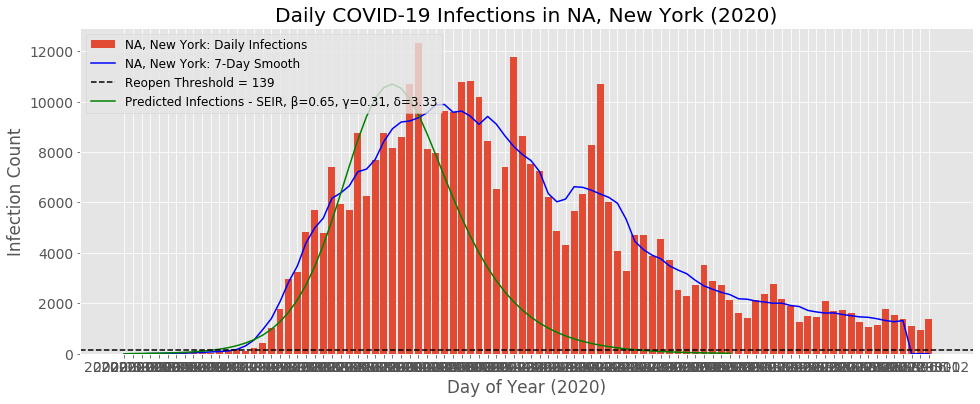

In [35]:
fig, ax = plt.subplots(figsize = (16,6))

plt.bar(df2.date, df2['daily_cases'], label = f"{region_init[1]}, {region_init[0]}: Daily Infections")
plt.plot(df2.date, df2[f'daily_cases_roll{num_days_smooth}mean'], 
         label = f"{region_init[1]}, {region_init[0]}: {num_days_smooth}-Day Smooth", color='blue')
plt.plot(t, I, label = f'Predicted Infections - SEIR, β={beta:.2f}, γ={gamma:.2f}, δ={delta:.2f}',
         color = 'green')
ax.axhline(state_reopen_thresh, color = 'black', ls="--", 
           label = f"Reopen Threshold = {state_reopen_thresh}")

# ax.xaxis.set_major_locator(MultipleLocator(5))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# # For the minor ticks, use no labels; default NullFormatter.
# ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.tick_params(direction='out', length=10)
ax.set_xlabel('Day of Year (2020)')
ax.set_ylabel('Infection Count')
# ax.set_yscale('log')
plt.title(f'Daily COVID-19 Infections in {region_init[1]}, {region_init[0]} (2020)')
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12,loc='upper left')
plt.show();
# fig.savefig('../images/seir_fit_to_NY_infections-01.png', dpi=250)

## MCMC examples and testing

In [5]:
N = 1000
beta = 1.0 # infected person infects 1 other person per day
D = 4.0 # infections last 4 days
gamma = 1.0 / D
delta = 1.0 / 3 # incubation period of 3 days

S0, E0, I0, R0 = N-1, 1, 0, 0

In [6]:
def deriv_seir_fixed(y, t, N, beta, gamma, delta):
    S, E, I, R = y

    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    
    return dSdt, dEdt, dIdt, dRdt

In [7]:
t = np.linspace(50,150,100)
# Initial conditions vector
y0 = S0, E0, I0, R0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_seir_fixed, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

In [8]:
def plotseir(t, S, E, I, R, R0=None):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population Count')
    plt.title(f'SEIR, β={beta:.2f}, γ={gamma:.2f}, δ={delta:.2f}')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();
    f.savefig(f"../images/generic_seir_trends.png", dpi=250)

    if R0 is not None:
        f = plt.figure(figsize=(12,4))
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    plt.show();

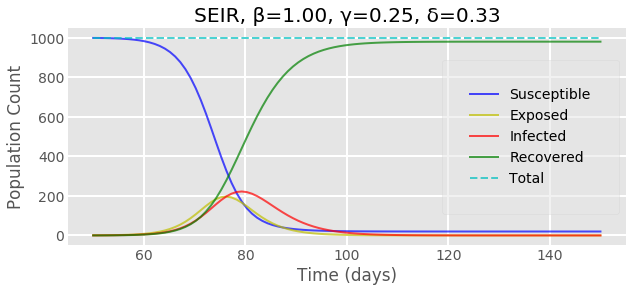

In [9]:
plotseir(t, S, E, I, R)

## Functions and Classes

In [36]:
# Get data
def get_state_or_county_data(region, num_days = 7):
    '''
    Extracts the daily and cumulative totals of infections and deaths for a given region,
        as well as population for that region.  
    
    INPUT:
        - region: A tuple for the region of interest, of the form ('State':'County').
            The County should not have the term 'County' in it.
            Data for the entire state can be extracted by listing the 'NA' for the county.
        - num_days: number of days to apply centered rolling average
    OUTPUT: 
        - df_cases_deaths: A Pandas dataframe with time series of infections 
            and deaths (total and daily) for the specified region
        - region_pop: (Int64) Population (2019 estimate) for the specified region 
    '''
    if region[1]=='NA':
        df_cases = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
        df_cases_region = df_cases.loc[(df_cases['state']==region[0])].reset_index()
        county_popul = region[0]
    else:
        df_cases = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
        df_cases_region = df_cases.loc[(df_cases['state']==region[0]) & (df_cases['county'].str.startswith(region[1]))].reset_index()
        county_popul = region[1] + ' County'
        
    df_cases_region['daily_cases'] = df_cases_region['cases'] - df_cases_region['cases'].shift(1)
    df_cases_region['daily_cases'].fillna(value=0, inplace=True)
    df_cases_region['daily_deaths'] = df_cases_region['deaths'] - df_cases_region['deaths'].shift(1)
    df_cases_region['daily_deaths'].fillna(value=0, inplace=True)
    df_cases_region[f'daily_cases_roll{num_days}mean'] = df_cases_region['daily_cases'].rolling(window=num_days, center = True).mean()
    df_cases_region[f'daily_cases_roll{num_days}mean'].fillna(value=0, inplace=True)
   
    cols_to_move = ['cases', 'daily_deaths','deaths']
    df_cases_region = df_cases_region[[ col for col in df_cases_region.columns if col not in cols_to_move] + cols_to_move]
    
    df_pop = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv', encoding='latin-1')
    region_pop = df_pop.loc[(df_pop['STNAME']==region[0]) & (df_pop['CTYNAME']==county_popul), 'POPESTIMATE2019'].values[0]
    
    return df_cases_region, region_pop

In [37]:
def deriv_seir(y, t, N, beta, gamma, delta):
    '''
    Calculates the net change in population for each compartment of the SEIR model
        at a given time t.
    
    INPUT:
        - y:     a variable packed with the 4 compartments of the SEIR model
        - t:     the time at which the rates will be calculated
        - N:     the total population available; equals the sum of S+E+I+R
        - beta:  the expected amount of people an infected person infects per day
        - gamma: the fraction of infected people recovering per day (= 1 / D, where D is the
            number of days an infected person has and can spread the disease).
        - delta: length of incubation period (how long a person is Exposed before becoming Infected)
    OUTPUT: 
        - dSdt: the net change of Susceptible people for the time, t, given
        - dEdt: the net change of Exposed     people for the time, t, given
        - dIdt: the net change of Infected    people for the time, t, given
        - dRdt: the net change of Recovered   people for the time, t, given
    '''
    S, E, I, R = y

    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    
    return dSdt, dEdt, dIdt, dRdt

In [38]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    '''
    Models the expected change in R_0 (R-naught) from a behavior change event (e.g., lockdown or opening up)
        as a logistic change from one value to a subsequent one, rather than as a single step change.
    
    INPUT:
        - t: the time at which the rates will be calculated
        - R_0_start: R0 before the behavior change event
        - k: parameter to control the rate at which the transition from R_0_start to R_0_end occurs.
        - x0: 'change inflection date' - the center point in the transition from R_0_start to R_0_end. 
        - R_0_end: R0 before the behavior change event
    OUTPUT: 
        - a time based series of R_0 values showing a single transition from R_0_start to R_0_end.
    '''
    return (R_0_start - R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

In [39]:
def Model(days, N, R_0_start, k, x0, R_0_end):
    '''
    Creates the SEIR model
    
    INPUT:
        - days:
        - N:
        - R_0_start: R0 before the behavior change event
        - k: parameter to control the rate at which the transition from R_0_start to R_0_end occurs.
        - x0: 'change inflection date' - the center point in the transition from R_0_start to R_0_end. 
        - R_0_end: R0 before the behavior change event
    OUTPUT: 
        - t: the time at which the rates will be calculated
        - S: time series of Susceptible people
        - E: time series of Exposed people
        - I: time series of Infected people
        - R: time series of Recovered people
        - R_0_t: a time based series of R_0 values showing a single transition from R_0_start to R_0_end.
    '''
    
    def beta(t):
        '''
        Derives the expected change in beta across a behavior change event, 
            given the change in R_0_t, where beta = R_0_t * gamma

        INPUT:
            - t: the time at which the rates will be calculated
        OUTPUT: 
            - beta_t: a time based series of beta values showing a single transition from
                R_0_start to R_0_end
        '''
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    
    # Initial conditions vector
    S0, E0, I0, R0 = N-1, 1, 0, 0
    y0 = S0, E0, I0, R0
    
    t = np.linspace(0,days-1,days)
    
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_seir, y0, t, args=(N, beta, gamma, delta))
    S, E, I, R = ret.T
    
    R_0_t = [beta(i)/gamma for i in range(len(t))]
    
    return t, S, E, I, R, R_0_t

In [40]:
N = 1000
# infected person infects 1 other person per day
# beta = 1.0
# D = Num of days that infections last
D = 9.0
gamma = 1.0 / D
# incubation period of 3 days
delta = 1.0 / 3 

In [41]:
plt.gcf().subplots_adjust(bottom=0.15)

def plot_generic(t, S, E, I, R, R_0, x_ticks=None):

    # general SEIR curves
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    
    # Plot R_0_t
    f = plt.figure(figsize=(20,4))
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

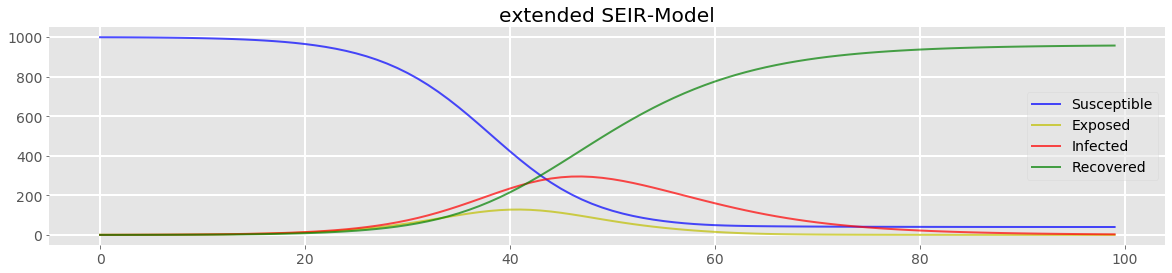

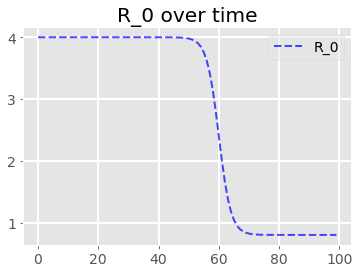

In [42]:
plot_generic(*Model(days=100, N=1000, R_0_start=4.0, k=0.5, x0=60, R_0_end=0.80))

In [43]:
region = ('New York','New York')
num_days_smooth = 7
df_cases_region, region_pop = get_state_or_county_data(region, num_days=num_days_smooth)

In [44]:
df_cases_region

,index,date,county,state,fips,daily_cases,daily_cases_roll7mean,cases,daily_deaths,deaths
0,416,2020-03-01,New York City,New York,NaN,0.0,0.000000,1,0.0,0
1,448,2020-03-02,New York City,New York,NaN,0.0,0.000000,1,0.0,0
2,482,2020-03-03,New York City,New York,NaN,1.0,0.000000,2,0.0,0
3,518,2020-03-04,New York City,New York,NaN,0.0,1.571429,2,0.0,0
4,565,2020-03-05,New York City,New York,NaN,2.0,1.857143,4,0.0,0
...,...,...,...,...,...,...,...,...,...,...
89,187405,2020-05-29,New York City,New York,NaN,946.0,711.571429,206800,65.0,20960
90,190388,2020-05-30,New York City,New York,NaN,739.0,726.285714,207539,31.0,20991
91,193376,2020-05-31,New York City,New York,NaN,546.0,0.000000,208085,59.0,21050
92,196368,2020-06-01,New York City,New York,NaN,465.0,0.000000,208550,40.0,21090


In [45]:
df_cases_region[f'daily_cases_roll{num_days_smooth}mean']

0       0.000000
1       0.000000
2       0.000000
3       1.571429
4       1.857143
         ...    
89    711.571429
90    726.285714
91      0.000000
92      0.000000
93      0.000000
Name: daily_cases_roll7mean, Length: 94, dtype: float64

In [46]:
data = df_cases_region[f'daily_cases_roll{num_days_smooth}mean'][0:40]

outbreak_shift = 0

# parameters to fit; form: {parameter: (initial guess, minimum value, max value)}
params_init_min_max = {"R_0_start": (3.0, 2.0, 20.0), 
                       "k": (2.5, 0.01, 5.0), 
                       "x0": (20, 0, 120), 
                       "R_0_end": (0.9, 0.3, 8.0)}

In [47]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

In [48]:
def fitter(x, R_0_start, k, x0, R_0_end):
    ret = Model(days, N, R_0_start, k, x0, R_0_end)
    return ret[3][x]

In [49]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [50]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

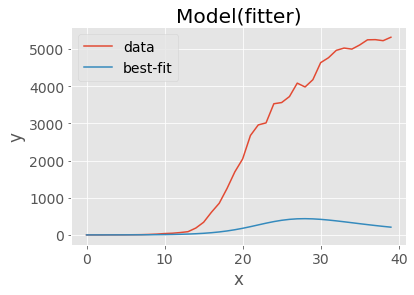

In [51]:
result.plot_fit(datafmt="-");

In [52]:
result.best_values

{'R_0_start': 8.118362368348135,
 'k': 2.523079514118616,
 'x0': 38.98287048686763,
 'R_0_end': 4.031430091959576}

In [ ]:
alpha = 2
beta = 2

niter = 1000
with pm.Model() as model: # context management
    # define priors
    p = pm.Beta('p', alpha=alpha, beta=beta)

    # define likelihood
    y = pm.Binomial('y', n=n, p=p, observed=h)

    # inference
    start = pm.find_MAP() # Use MAP estimate (optimization) as the initial state for MCMC
    step = pm.Metropolis() # Have a choice of samplers
    trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)

In [ ]:
plt.gcf().subplots_adjust(bottom=0.15);

def plot_with_region(t, S, E, I, R, R_0, x_ticks=None):

    # general SEIR curves
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    # Overlay of I with location
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

In [ ]:
# https://docs.pymc.io/notebooks/getting_started.html
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)